### Machine learning in geoscience with scikit-learn - notebook 1
Matteo Niccoli, MyCarta - Calgary, Alberta, Canada

mycarta.wordpress.com

matteo@mycarta.ca

This is the first notebook in a series about Machine Learning in geoscience. The overall **goal** of this series of notebooks is to **predict P-wave velocity from other geophysical logs** using Machine Learning. The aspiration is to show that some of these models perform better thn multivariate linear regression.

The notebook accompany a <a href="https://mycarta.wordpress.com/2016/10/01/machine-learning-in-geoscience-with-scikit-learn-series-outline/"> series of blog post on MyCarta</a>:

1) Machine learning in geoscience with scikit-learn. Part 1: checking, tidying, and analyzing the dataset

2) Machine learning in geoscience with scikit-learn. Part 2: using inferential statistics to select featues

3) Machine learning in geoscience with scikit-learn. Part 3: evaluating and comparing algorithms

4) Machine learning in geoscience with scikit-learn. Part 4: improving results with algorithm tuning

#### PRELIMINARIES

First we import the libraries we will need.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

#### IMPORT, CHECK, AND TIDY THE DATA

##### Import and quick summary

We will use the same dataset of the <a href="https://github.com/seg/tutorials-2015#tutorials-2015"> Seismic Petrophysics SEG tutorial</a> by <a href="https://github.com/aadm"> Alessandro Amato del Monte</a>.

We load the logs from a csv file as a Pandas DataFrame, and check the data by printing the column names and types, and the first and last 6 rows of data.

In [3]:
logs = pd.read_csv('qsiwell2_predict.csv')

print logs.columns
# print(logs.dtypes)
print (logs.head(6))
print (logs.tail(6))

Index([u'DEPTH', u'VP', u'VS', u'RHO_OLD', u'GR', u'NPHI', u'RHO', u'SW',
       u'SWX', u'VPVS', u'IP', u'IS', u'VSH', u'RHOm', u'RHOf', u'PHI'],
      dtype='object')
     DEPTH      VP     VS  RHO_OLD     GR  NPHI   RHO   SW  SWX  VPVS  \
0  2013.25  2294.7  876.9     2.00  91.88  0.49   NaN  NaN  NaN  2.62   
1  2013.41  2296.7  943.0     2.05  86.80  0.48  2.24  1.0  1.0  2.44   
2  2013.56  2290.4  912.5     2.11  86.00  0.45  2.24  1.0  1.0  2.51   
3  2013.71  2277.5  891.6     2.20  87.36  0.41  2.24  1.0  1.0  2.55   
4  2013.86  2262.0  890.5     2.20  90.40  0.43  2.24  1.0  1.0  2.54   
5  2014.01  2263.1  863.1     2.17  93.31  0.47  2.24  1.0  1.0  2.62   

        IP       IS   VSH  RHOm  RHOf   PHI  
0      NaN      NaN  0.49  2.73   NaN   NaN  
1  5144.85  2112.42  0.44  2.72  1.09  0.29  
2  5135.74  2046.09  0.43  2.72  1.09  0.29  
3  5107.98  1999.68  0.44  2.72  1.09  0.29  
4  5067.02  1994.78  0.48  2.73  1.09  0.30  
5  5063.48  1931.11  0.51  2.73  1.09  0.30

##### Drop unwanted columns

We want to keep the target P-wave velocity log (VP), and the feature logs Gamma Ray (GR), Neutron (NPHI), Density (RHO), and DEPTH. Let's remove the remaining columns, and also the first row, which had a NaN for RHO, and check the data again.

In [4]:
col_names = ['VS','RHO_OLD','SW','SWX','VPVS','IP','IS','VSH','RHOm','RHOf','PHI']
logs.drop(col_names, axis=1, inplace=True)

logs=logs.iloc[1:,:] 
 
print (logs.head(3))

     DEPTH      VP     GR  NPHI   RHO
1  2013.41  2296.7  86.80  0.48  2.24
2  2013.56  2290.4  86.00  0.45  2.24
3  2013.71  2277.5  87.36  0.41  2.24


##### Printing a quick summary

First I want to move the target to the last column.

In [5]:
logs = logs[['DEPTH', 'GR', 'NPHI', 'RHO', 'VP']]

Now that we only have the columns we are interested in, we can use pandas.describe to get some statistics to "summarize" the data.

In [6]:
logs.describe(percentiles=[.05, .25, .75, .95])

,DEPTH,GR,NPHI,RHO,VP
count,4116.000000,4116.000000,4116.000000,2701.000000,4116.000000
mean,2326.968200,72.780209,0.321259,2.225198,2977.264553
std,181.101671,14.463176,0.089937,0.061964,449.284198
min,2013.410000,48.370000,0.070000,2.040000,1439.900000
5%,2044.762500,56.785000,0.090000,2.120000,2301.700000
25%,2170.182500,60.680000,0.280000,2.190000,2594.575000
50%,2326.965000,68.020000,0.310000,2.220000,3036.300000
75%,2483.747500,83.537500,0.390000,2.260000,3251.100000
95%,2609.177500,100.490000,0.460000,2.330000,3886.925000
max,2640.530000,136.510000,0.530000,2.550000,4431.000000


Notice that the default percentiles are 25, 50, 75, but I added the 5 and 95 by passing an optional argument. If you are curious as to how we could instead acces a subset of the statistics from pandas.describe, check <a href="http://stackoverflow.com/questions/19124148/modify-output-from-python-pandas-describe"> this Stackoverflow question.</a>

The table above is useful as it gives us an idea of the distribution of the data in each column. 

We could add other rows, for example the median, by:

1) turning the above table into a separate DataFrame

2) creating a new DataFrame with just the individual column median values

3) <a href="http://pandas.pydata.org/pandas-docs/stable/merging.html"> concatenating the two DataFrames</a>

In [7]:
np.set_printoptions(precision=2)

desc = pd.DataFrame(logs.describe().as_matrix(),index=list(logs.describe().index), 
                    columns=list(logs.describe().columns))
desc

,DEPTH,GR,NPHI,RHO,VP
count,4116.000000,4116.000000,4116.000000,2701.000000,4116.000000
mean,2326.968200,72.780209,0.321259,2.225198,2977.264553
std,181.101671,14.463176,0.089937,0.061964,449.284198
min,2013.410000,48.370000,0.070000,2.040000,1439.900000
25%,2170.182500,60.680000,0.280000,2.190000,2594.575000
50%,2326.965000,68.020000,0.310000,2.220000,3036.300000
75%,2483.747500,83.537500,0.390000,2.260000,3251.100000
max,2640.530000,136.510000,0.530000,2.550000,4431.000000


In [8]:
medn = pd.DataFrame(data=[list(logs.median(axis=0).as_matrix())], 
                    index = ['median'], columns = logs.describe().columns)
medn

,DEPTH,GR,NPHI,RHO,VP
median,2326.965,68.02,0.31,2.22,3036.3


In [9]:
frames = [desc, medn]
desc = pd.concat(frames)
desc

,DEPTH,GR,NPHI,RHO,VP
count,4116.000000,4116.000000,4116.000000,2701.000000,4116.000000
mean,2326.968200,72.780209,0.321259,2.225198,2977.264553
std,181.101671,14.463176,0.089937,0.061964,449.284198
min,2013.410000,48.370000,0.070000,2.040000,1439.900000
25%,2170.182500,60.680000,0.280000,2.190000,2594.575000
50%,2326.965000,68.020000,0.310000,2.220000,3036.300000
75%,2483.747500,83.537500,0.390000,2.260000,3251.100000
max,2640.530000,136.510000,0.530000,2.550000,4431.000000
median,2326.965000,68.020000,0.310000,2.220000,3036.300000


##### Dealing with missing values

The first row is showing that we are missing about 1/3 of samples in the density column RHO. Let's use pandas.isnull for a more thorough check. pandas.isnull tells us if a column has any null values. We will also use the sum method to get the number of null values.

In [10]:
for x in logs.columns:
  print x, logs[x].isnull().values.any()

print logs.isnull().sum() 

DEPTH False
GR False
NPHI False
RHO True
VP False
DEPTH       0
GR          0
NPHI        0
RHO      1415
VP          0
dtype: int64


It looks like there are 1415 null values in the density log. 

One way to deal with the missing values would be to find out to which rows they belong to and eliminate those rows for all columns, but that would mean losing 1/3 of good values in the other columns.

I prefer for the moment to replace missing density values with the mean density ('mean imputation'). We will revisit this decision at a later stage during prediction when we evaluate the relative importance of each feature in predicting P-wave velocity. If RHO happened to be the most important feature, we may want to consider deleting those rows to not bias the analysis. 

In [11]:
logs['RHO'].fillna(logs['RHO'].mean(),inplace=True)

for x in logs.columns:
  print x, logs[x].isnull().values.any() 

DEPTH False
GR False
NPHI False
RHO False
VP False


We checked again, and there are no more null values in our data set. By the way, I found some very good examples on the various ways to deal with missing data in Pandas dataframes in <a href="http://chrisalbon.com/python/pandas_missing_data.html"> this article</a>.

##### Other issues

Let us go one step further and visually inspect all the logs by plotting them.

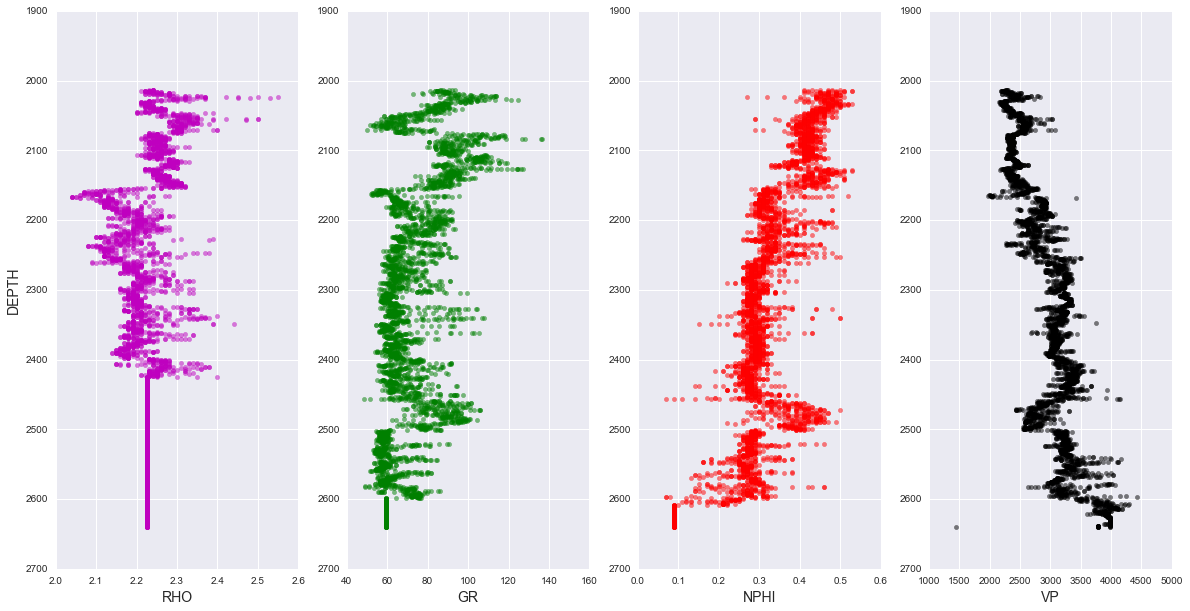

In [12]:
fig = plt.figure(figsize=(20, 10)) 

ax1 = fig.add_subplot(1, 4, 1)
ax1.scatter(logs['RHO'], logs['DEPTH'], color = 'm', alpha=0.5)
ax1.set_ylabel('DEPTH', fontsize = '14' )
ax1.set_xlabel('RHO', fontsize = '14')
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(1, 4, 2)
ax2.scatter(logs['GR'], logs['DEPTH'], color = 'g', alpha=0.5)
ax2.set_xlabel('GR', fontsize = '14')
plt.gca().invert_yaxis()

ax3 = fig.add_subplot(1, 4, 3)
ax3.scatter(logs['NPHI'], logs['DEPTH'], color = 'r', alpha=0.5)
ax3.set_xlabel('NPHI', fontsize = '14')
plt.gca().invert_yaxis()

ax4 = fig.add_subplot(1, 4, 4)
ax4.scatter(logs['VP'], logs['DEPTH'], color = 'k', alpha=0.5)
ax4.set_xlabel('VP', fontsize = '14')
plt.gca().invert_yaxis()

plt.show()

First thing I notice is that there's one data point at the bottom of the VP log showing unrealistically low velocity.
It looks like it is the lowest value of VP so it is easily highlighted (for display purposes) and eliminated.

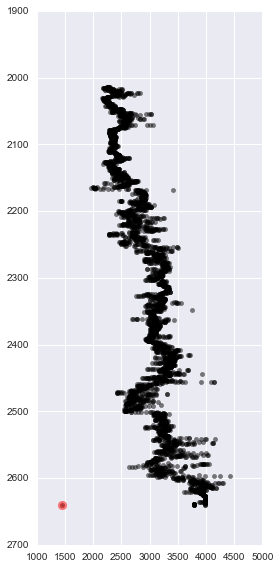

In [13]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs['VP'], logs['DEPTH'], color = 'k', alpha=0.5)
templogs = logs[(logs['VP']==logs['VP'].min())]
ax1.scatter(templogs['VP'], templogs['DEPTH'], s=75, color = 'r', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Now we can remove the data point, then plot again.

In [14]:
logs = logs[~(logs['VP']==logs['VP'].min())]

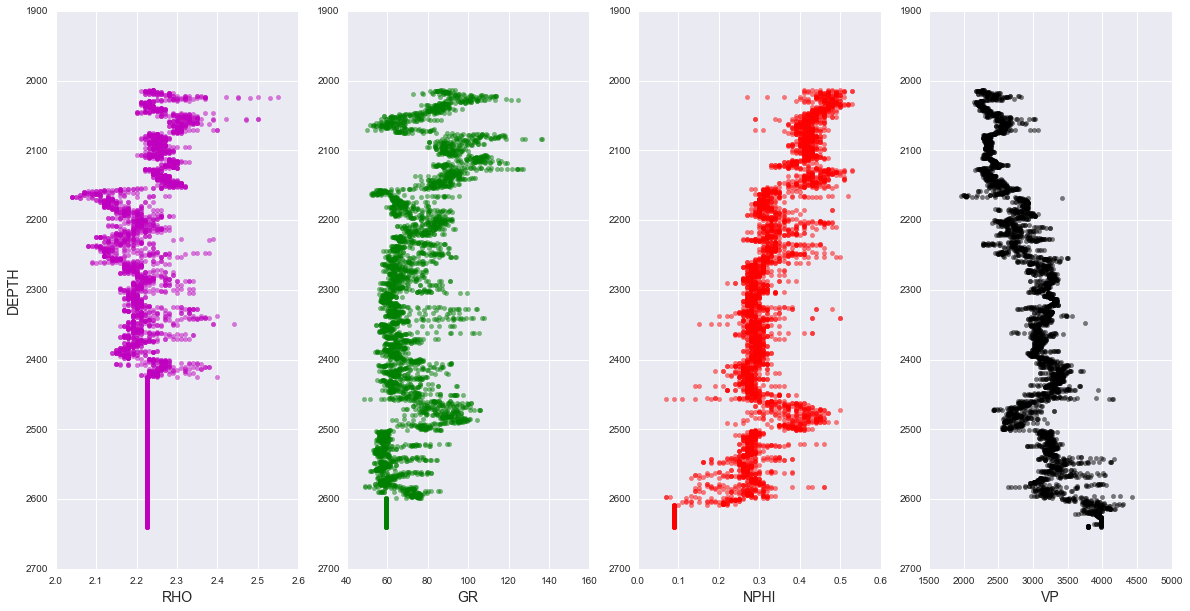

In [15]:
fig = plt.figure(figsize=(20, 10)) 

ax1 = fig.add_subplot(1, 4, 1)
ax1.scatter(logs['RHO'], logs['DEPTH'], color = 'm', alpha=0.5)
ax1.set_ylabel('DEPTH', fontsize = '14' )
ax1.set_xlabel('RHO', fontsize = '14')
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(1, 4, 2)
ax2.scatter(logs['GR'], logs['DEPTH'], color = 'g', alpha=0.5)
ax2.set_xlabel('GR', fontsize = '14')
plt.gca().invert_yaxis()

ax3 = fig.add_subplot(1, 4, 3)
ax3.scatter(logs['NPHI'], logs['DEPTH'], color = 'r', alpha=0.5)
ax3.set_xlabel('NPHI', fontsize = '14')
plt.gca().invert_yaxis()

ax4 = fig.add_subplot(1, 4, 4)
ax4.scatter(logs['VP'], logs['DEPTH'], color = 'k', alpha=0.5)
ax4.set_xlabel('VP', fontsize = '14')
plt.gca().invert_yaxis()

plt.show()

The next thing I noticed is that both GR and NPHI end with a sequence of constant values. 

I want to be sure that those are also made equal to the respective mean value (for now).

To do that, I modified an idea from <a href="http://stackoverflow.com/a/14360423/1034648"> this StackOverflow answer</a>. I will:

First create a separate DataFrame with just the GR log. 

Next add a second column to the new DataFrame to label blocks of consecutive repeated values (the repeated numbers are found by shifting the GR log itself by 1 sample and comparing the shifted to the original).

Finally replace all GR values in the last block (maximum block label value) of the original DatFrame with the log's mean value.

The GR values for the last 3 rows are printed at the beginning and at the end to show this was succesfull.

In [16]:
print logs.tail(3)
gamma = pd.DataFrame(logs['GR'])
gamma['block']= (gamma.GR.shift(1) != gamma.GR).astype(int).cumsum()
logs['GR'][gamma['block']==max(gamma['block'])]=logs['GR'].mean()
print logs.tail(3)

        DEPTH     GR  NPHI       RHO      VP
4113  2640.07  59.18  0.09  2.225198  3786.8
4114  2640.23  59.18  0.09  2.225198  3974.8
4115  2640.38  59.18  0.09  2.225198  3974.8
        DEPTH         GR  NPHI       RHO      VP
4113  2640.07  72.783514  0.09  2.225198  3786.8
4114  2640.23  72.783514  0.09  2.225198  3974.8
4115  2640.38  72.783514  0.09  2.225198  3974.8


We repeat the same process for NPHI then plot all 4 logs again.

In [17]:
print logs.tail(3)
neutron = pd.DataFrame(logs['NPHI'])
neutron['block']= (neutron.NPHI.shift(1) != neutron.NPHI).astype(int).cumsum()
logs['NPHI'][neutron['block']==max(neutron['block'])]=logs['NPHI'].mean()
print logs.tail(3)

        DEPTH         GR  NPHI       RHO      VP
4113  2640.07  72.783514  0.09  2.225198  3786.8
4114  2640.23  72.783514  0.09  2.225198  3974.8
4115  2640.38  72.783514  0.09  2.225198  3974.8
        DEPTH         GR      NPHI       RHO      VP
4113  2640.07  72.783514  0.321315  2.225198  3786.8
4114  2640.23  72.783514  0.321315  2.225198  3974.8
4115  2640.38  72.783514  0.321315  2.225198  3974.8


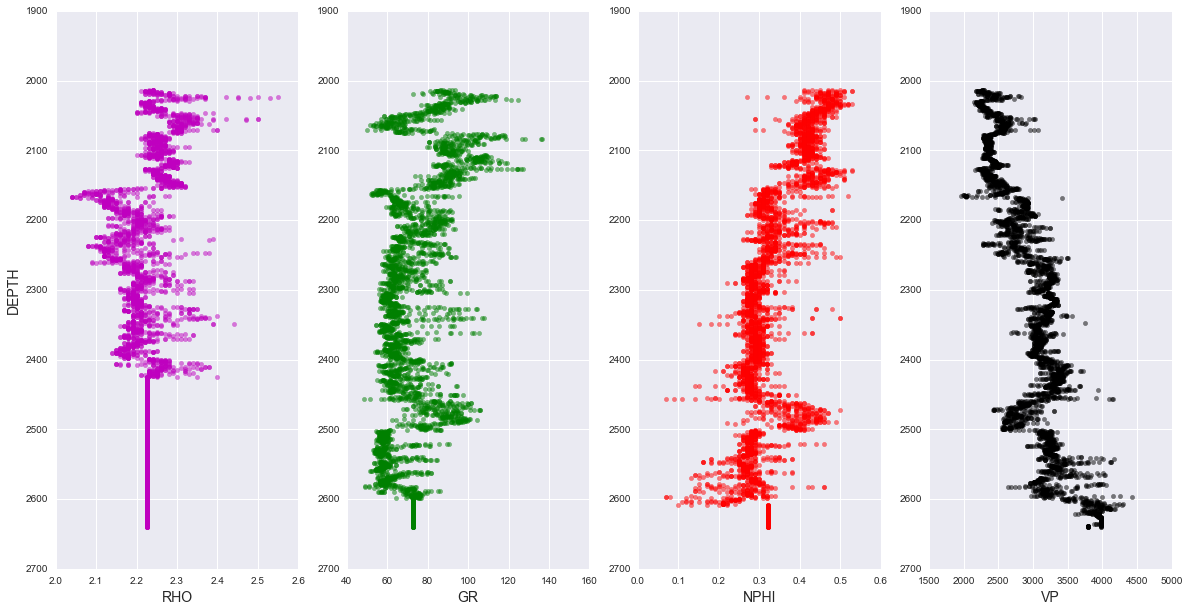

In [18]:
fig = plt.figure(figsize=(20, 10)) 

ax1 = fig.add_subplot(1, 4, 1)
ax1.scatter(logs['RHO'], logs['DEPTH'], color = 'm', alpha=0.5)
ax1.set_ylabel('DEPTH', fontsize = '14' )
ax1.set_xlabel('RHO', fontsize = '14')
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(1, 4, 2)
ax2.scatter(logs['GR'], logs['DEPTH'], color = 'g', alpha=0.5)
ax2.set_xlabel('GR', fontsize = '14')
plt.gca().invert_yaxis()

ax3 = fig.add_subplot(1, 4, 3)
ax3.scatter(logs['NPHI'], logs['DEPTH'], color = 'r', alpha=0.5)
ax3.set_xlabel('NPHI', fontsize = '14')
plt.gca().invert_yaxis()

ax4 = fig.add_subplot(1, 4, 4)
ax4.scatter(logs['VP'], logs['DEPTH'], color = 'k', alpha=0.5)
ax4.set_xlabel('VP', fontsize = '14')
plt.gca().invert_yaxis()

plt.show()

##### TEST THE DATA

Randy Olson mentioned an idea from SciPy 2015 in <a href="https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb"> this great Data Analysis and Machine Learning Notebook</a>: testing our expectations about the data with 'assert' statements. 

It is an interesting idea and so I included some examples below, starting with an intentionally erroneous assertion about the minimum P-wave value, which will make the first test fail:

In [19]:
assert logs['VP'].min() > 2000

AssertionError: 

but with a lower value, the test should pass:

In [20]:
assert logs['VP'].min() > 1950

and since we eliminated missing measurements from RHO, this test also should pass:

In [21]:
assert len(logs.loc[(logs['RHO'].isnull())]) == 0

##### VISUALIZE THE DATA

Using Seaborn, we can now create a scatter matrix showing the pairwise scatterplots between all logs (features, and target VP) and the individual hystogram distribution in the main diagonal. We will look at the pairwise correlation coefficients separately.

This can help learn the data, and answer several questions, among which:

- are there obvious distributions (normal, exponential, etc.)?


- are there any obvious linear relationships between the target and any of the feature logs?


- Are there features that correlate highly between one another? For example, one could use this to look for features that have pairwise correlation coefficient r > 0.9, and eliminate one of the two ('attribute culling').


- Are there features that are not significant (in an inferential sense).  One could decide to drop any of the feature logs that had correlation coefficient with the target log lower than a critical r. 

For more on these topics, specifically in Python, please see: <a href="http://greenteapress.com/thinkstats/html/index.html"> Think Stats, by Allen B. Downey</a>.

In the remainder of this notebook I will touch briefly on the questions above, and make some observations. I will dig deeper in the last two points in the next notebook, which is specifically on inferential statistics.


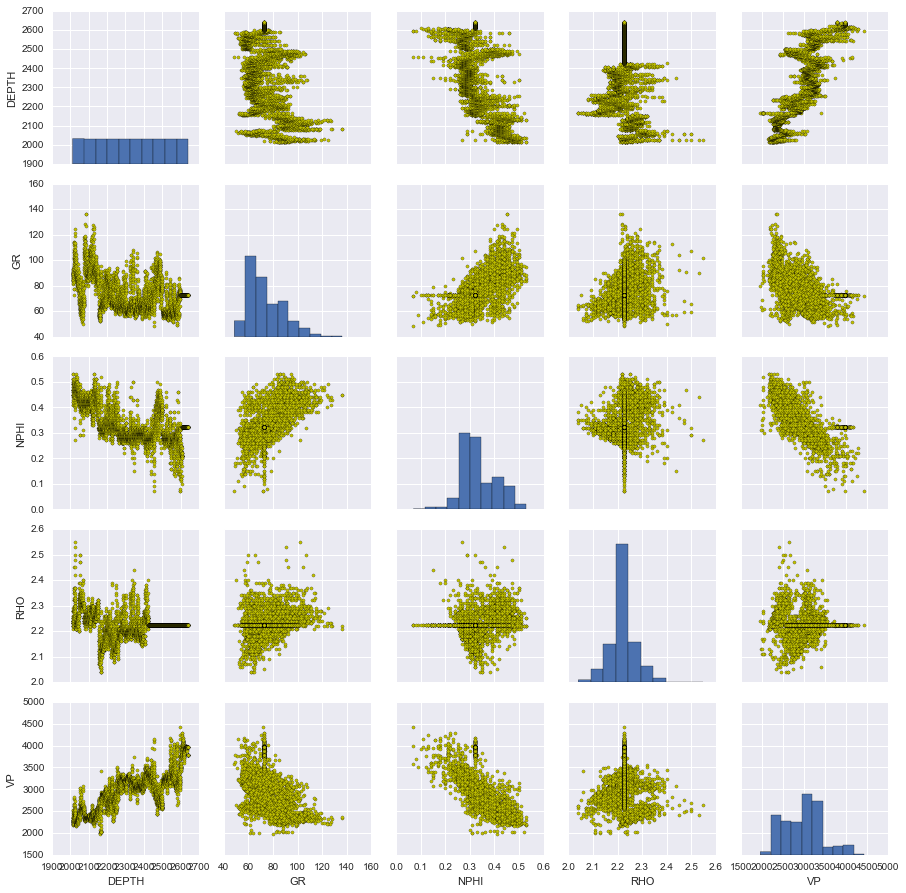

In [22]:
g = sns.PairGrid(logs)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s=10, color = "y", edgecolor="k", linewidth= 0.2);

We can print the (Pearson) correlation coefficients as a matrix.

In [23]:
logs.corr() 

,DEPTH,GR,NPHI,RHO,VP
DEPTH,1.000000,-0.419447,-0.643980,-0.151884,0.808493
GR,-0.419447,1.000000,0.703454,0.369199,-0.549545
NPHI,-0.643980,0.703454,1.000000,0.286145,-0.751977
RHO,-0.151884,0.369199,0.286145,1.000000,-0.147060
VP,0.808493,-0.549545,-0.751977,-0.147060,1.000000


We can also get the Spearman correlation coefficients as a matrix. The Spearman cefficient is at time more suitable if the data has outliers, skewed distributions / non linear relationships. In this case (see below) the differences are minor.

In [24]:
logs.corr(method = 'spearman') 

,DEPTH,GR,NPHI,RHO,VP
DEPTH,1.000000,-0.378742,-0.609099,-0.183970,0.793303
GR,-0.378742,1.000000,0.708752,0.419804,-0.554329
NPHI,-0.609099,0.708752,1.000000,0.303800,-0.772807
RHO,-0.183970,0.419804,0.303800,1.000000,-0.211357
VP,0.793303,-0.554329,-0.772807,-0.211357,1.000000


You can access these values with the as_matrix method:

In [25]:
np.set_printoptions(precision=2)
pc= logs.corr(method = 'spearman').as_matrix()
print pc

[[ 1.   -0.38 -0.61 -0.18  0.79]
 [-0.38  1.    0.71  0.42 -0.55]
 [-0.61  0.71  1.    0.3  -0.77]
 [-0.18  0.42  0.3   1.   -0.21]
 [ 0.79 -0.55 -0.77 -0.21  1.  ]]


Nice. But I would like to turn these values into something more visual. I will use a modified Seaborn heatmap, drawing from an example in <a href="http://photo.etangkk.com/Python/blog-04.asp"> this great article</a>.


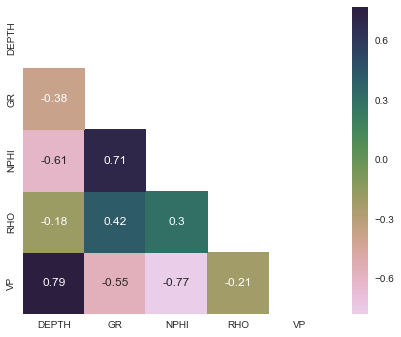

In [26]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(logs.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(logs.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

My first impressions by looking at the scatterplots and inspecting the correlation coefficient map is that:

- the variables looks normally distributed for the most part.


- there is some hope to predict the sonic from the other logs; I see some linear trends and relatively significant coefficients. In particular, VP correlates the most with depth. This does not surprise me due to the physical expectation that - in general - rocks be stiffer with increasing depth of burial, and hence have higher VP; secondly, VP also correlates highly with NPHI. This is also fitting our a-priory knowledge that neutron is similar to sonic, it responds to shales in much the same way (no shale correction necessary). Additionally, neutron is not so much affected by noise and bad hole as other logs.


- Should we use both GR and NPHI?

- Should we use density?